In [317]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Linear, BatchNorm2d, Dropout2d
from torch.nn.init import kaiming_uniform_, xavier_uniform_
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [318]:
class GRSDataset(Dataset):
    def __init__(self, dataframe, frame_dir, transform=None, sequence_length=16):
        self.data = dataframe.copy()
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        video_id = row["VIDEO"]
        label = int(row["GRS"])
        path = self.frame_dir / video_id

        frames = sorted(path.glob("*.jpg"))
        selected = frames[:self.sequence_length]
        if len(selected) == 0:
            raise IndexError(f"No frames found for video {video_id}")
        while len(selected) < self.sequence_length:
            selected.append(selected[-1])

        images = [self.transform(Image.open(f).convert("RGB")) for f in selected]
        return torch.stack(images), label


In [319]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

LABEL_PATH = Path("../data/labels/labels_task1.csv")
FRAME_DIR = Path("../data/frames")

df = pd.read_csv(LABEL_PATH)
available_videos = {p.name for p in FRAME_DIR.iterdir() if p.is_dir() and any(p.glob("*.jpg"))}
df = df[df["VIDEO"].isin(available_videos)].reset_index(drop=True)

dataset = GRSDataset(df, FRAME_DIR, transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [320]:
from sklearn.model_selection import train_test_split

# Divisão sem estratificação para evitar o erro
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Criar datasets
train_dataset = GRSDataset(train_df, FRAME_DIR, transform)
val_dataset = GRSDataset(val_df, FRAME_DIR, transform)
test_dataset = GRSDataset(test_df, FRAME_DIR, transform)

# Criar dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [321]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = ReLU()(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = ReLU()(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.block1 = self._create_block(64, 64, 1)
        self.block2 = self._create_block(64, 128, 2)
        self.block3 = self._create_block(128, 256, 2)
        self.block4 = self._create_block(256, 512, 2)
        self.linear = nn.Linear(512, num_classes)

    def _create_block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)

        out = ReLU()(self.bn1(self.conv1(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = nn.AvgPool2d(4)(out)
        out = out.view(B, T, -1).mean(dim=1)  # média temporal dos frames

        out = self.linear(out)
        return out

In [322]:
class CNNModel_1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, 3),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.layer2 = Sequential(
            Conv2d(32, 32, 3),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.fc1 = Linear(32*6*6, 100)  # para 32x32 input após convoluções e pools
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(100, 4)
        xavier_uniform_(self.fc2.weight)
        self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        return out


In [323]:
class CNNModel_2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 16, 3),
            ReLU(),
            MaxPool2d(2)
        )
        self.layer2 = Sequential(
            Conv2d(16, 32, 3),
            ReLU(),
            MaxPool2d(2)
        )
        self.fc1 = Linear(32*6*6, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        return out


In [324]:
class CNNModel_3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(
            Conv2d(3, 32, 3, padding=1),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            Conv2d(32, 64, 3),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(2)
        )
        self.fc1 = Linear(64*7*7, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(600, 120)
        self.fc3 = Linear(120, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


In [325]:
class CNNModel_4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(
            Conv2d(3, 32, 5),
            BatchNorm2d(32),
            ReLU(),
            MaxPool2d(2),
            Dropout2d(0.2)
        )
        self.fc1 = Linear(32*14*14, 128)
        self.fc2 = Linear(128, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [326]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super(CNNLSTMClassifier, self).__init__()

        # Carregar ResNet18 pré-treinada e remover a fully connected
        base_cnn = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_cnn.children())[:-1])  # até ao penúltimo bloco
        self.feature_dim = base_cnn.fc.in_features  # normalmente 512

        # LSTM para modelar a sequência de features
        self.lstm = nn.LSTM(input_size=self.feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)

        # Camada final para classificação
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)

        # Congelar CNN inicialmente (opcional)
        with torch.no_grad():
            features = self.feature_extractor(x).view(batch_size, seq_len, -1)

        lstm_out, _ = self.lstm(features)
        last_hidden = lstm_out[:, -1, :]
        out = self.classifier(last_hidden)
        return out


In [327]:
from torchvision import models

class EfficientNetLSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=4):
        super(EfficientNetLSTM, self).__init__()

        base = models.efficientnet_b0(pretrained=True)
        self.feature_extractor = base.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.feature_dim = 1280  # saída de efficientnet_b0

        self.lstm = nn.LSTM(input_size=self.feature_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,
                            batch_first=True)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()
        x = x.view(batch_size * seq_len, c, h, w)
        with torch.no_grad():
            features = self.pool(self.feature_extractor(x)).view(batch_size, seq_len, -1)

        out, _ = self.lstm(features)
        last = out[:, -1, :]
        return self.classifier(last)


In [328]:
from timm import create_model

class ViTTemporalAvg(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=4):
        super(ViTTemporalAvg, self).__init__()
        self.vit = create_model(model_name, pretrained=True)
        self.vit.head = nn.Identity()  # remover camada final
        self.feature_dim = self.vit.num_features

        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        with torch.no_grad():
            feats = self.vit(x).view(B, T, -1)

        avg_feats = feats.mean(dim=1)
        return self.classifier(avg_feats)

In [329]:
from pytorchvideo.models.hub import timesformer_base

class TimeSformerWrapper(nn.Module):
    def __init__(self, num_classes=4):
        super(TimeSformerWrapper, self).__init__()
        self.model = timesformer_base(pretrained=True)
        self.model.blocks[-1].drop_path_rate = 0.1
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

ImportError: cannot import name 'timesformer_base' from 'pytorchvideo.models.hub' (c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\pytorchvideo\models\hub\__init__.py)

In [ ]:
def validate_model(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss, correct / total

In [ ]:
def train_model(model, train_loader, epochs=5, val_loader=None):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_history = []
    
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_acc = train_correct / train_total
        
        if val_loader:  # Validação só ocorre se val_loader for fornecido
            val_loss, val_acc = validate_model(model, val_loader, criterion)
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            train_history.append((train_loss, train_acc, val_loss, val_acc))
        else:
            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            train_history.append((train_loss, train_acc))
    
    return train_history

In [ ]:
model = EfficientNetLSTM().to(device)
# Ou:
# model = ViTTemporalAvg().to(device)
# model = TimeSformerWrapper().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc, train_f1 = train_one_epoch(model, loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, loader, criterion)
    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")


c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'train_one_epoch' is not defined

In [331]:
model1 = CNNModel_1().to(device)
hist1 = train_model(model1, train_loader, 30)

Epoch 1: Train Loss: 7.6471, Train Acc: 0.3810
Epoch 2: Train Loss: 7.2234, Train Acc: 0.4762
Epoch 3: Train Loss: 7.2121, Train Acc: 0.4762
Epoch 4: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 5: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 6: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 7: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 8: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 9: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 10: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 11: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 12: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 13: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 14: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 15: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 16: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 17: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 18: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 19: Train Loss: 7.2120, Train Acc: 0.4762
Epoch 20: Train Loss: 7.9620, Train Acc: 0.4762
Epoch 21: Train Loss: 7.9620, Train Acc: 0.4762
E

In [332]:
model2 = CNNModel_2().to(device)
hist2 = train_model(model2, train_loader, 30)

Epoch 1: Train Loss: 8.0582, Train Acc: 0.2857
Epoch 2: Train Loss: 7.5980, Train Acc: 0.4762
Epoch 3: Train Loss: 7.3988, Train Acc: 0.4762
Epoch 4: Train Loss: 7.6994, Train Acc: 0.4762
Epoch 5: Train Loss: 6.5286, Train Acc: 0.5714
Epoch 6: Train Loss: 6.0486, Train Acc: 0.5714
Epoch 7: Train Loss: 5.5528, Train Acc: 0.5714
Epoch 8: Train Loss: 5.6547, Train Acc: 0.6190
Epoch 9: Train Loss: 5.0597, Train Acc: 0.5714
Epoch 10: Train Loss: 3.9691, Train Acc: 0.7143
Epoch 11: Train Loss: 5.1594, Train Acc: 0.6667
Epoch 12: Train Loss: 3.5337, Train Acc: 0.7619
Epoch 13: Train Loss: 3.3440, Train Acc: 0.7143
Epoch 14: Train Loss: 3.3210, Train Acc: 0.8095
Epoch 15: Train Loss: 2.6643, Train Acc: 0.8571
Epoch 16: Train Loss: 2.3661, Train Acc: 0.8095
Epoch 17: Train Loss: 2.1126, Train Acc: 0.8095
Epoch 18: Train Loss: 1.8152, Train Acc: 0.9048
Epoch 19: Train Loss: 1.5554, Train Acc: 1.0000
Epoch 20: Train Loss: 1.2719, Train Acc: 0.9524
Epoch 21: Train Loss: 1.1041, Train Acc: 1.0000
E

In [333]:
model3 = CNNModel_3().to(device)
hist3 = train_model(model3, train_loader, 30)

c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Train Loss: 14.1201, Train Acc: 0.5238
Epoch 2: Train Loss: 12.3533, Train Acc: 0.4286
Epoch 3: Train Loss: 19.9462, Train Acc: 0.5238
Epoch 4: Train Loss: 5.5647, Train Acc: 0.6190
Epoch 5: Train Loss: 5.9298, Train Acc: 0.7619
Epoch 6: Train Loss: 3.5521, Train Acc: 0.7619
Epoch 7: Train Loss: 6.3906, Train Acc: 0.8095
Epoch 8: Train Loss: 4.0274, Train Acc: 0.6667
Epoch 9: Train Loss: 2.0021, Train Acc: 0.8095
Epoch 10: Train Loss: 2.0762, Train Acc: 0.9524
Epoch 11: Train Loss: 0.4594, Train Acc: 0.9524
Epoch 12: Train Loss: 1.3227, Train Acc: 0.9524
Epoch 13: Train Loss: 3.0442, Train Acc: 0.8571
Epoch 14: Train Loss: 2.4896, Train Acc: 0.8571
Epoch 15: Train Loss: 0.3498, Train Acc: 0.9524
Epoch 16: Train Loss: 2.3581, Train Acc: 0.9048
Epoch 17: Train Loss: 0.7309, Train Acc: 0.9524
Epoch 18: Train Loss: 0.0489, Train Acc: 1.0000
Epoch 19: Train Loss: 0.7321, Train Acc: 0.9524
Epoch 20: Train Loss: 0.0055, Train Acc: 1.0000
Epoch 21: Train Loss: 0.5336, Train Acc: 0.904

In [334]:
model4 = CNNModel_4().to(device)
hist4 = train_model(model4, train_loader, 30)

Epoch 1: Train Loss: 36.2061, Train Acc: 0.2381
Epoch 2: Train Loss: 45.7203, Train Acc: 0.4762
Epoch 3: Train Loss: 23.0109, Train Acc: 0.6190
Epoch 4: Train Loss: 8.3705, Train Acc: 0.6667
Epoch 5: Train Loss: 9.1026, Train Acc: 0.7143
Epoch 6: Train Loss: 3.4604, Train Acc: 0.8571
Epoch 7: Train Loss: 2.9570, Train Acc: 0.8095
Epoch 8: Train Loss: 0.3466, Train Acc: 0.9524
Epoch 9: Train Loss: 3.1197, Train Acc: 0.9048
Epoch 10: Train Loss: 0.1459, Train Acc: 1.0000
Epoch 11: Train Loss: 1.5254, Train Acc: 0.8571
Epoch 12: Train Loss: 0.3627, Train Acc: 0.9524
Epoch 13: Train Loss: 0.9904, Train Acc: 0.9524
Epoch 14: Train Loss: 0.0449, Train Acc: 1.0000
Epoch 15: Train Loss: 0.9118, Train Acc: 0.9524
Epoch 16: Train Loss: 2.7343, Train Acc: 0.8571
Epoch 17: Train Loss: 0.2251, Train Acc: 0.9524
Epoch 18: Train Loss: 0.4892, Train Acc: 0.9524
Epoch 19: Train Loss: 0.0064, Train Acc: 1.0000
Epoch 20: Train Loss: 0.0021, Train Acc: 1.0000
Epoch 21: Train Loss: 0.0044, Train Acc: 1.000

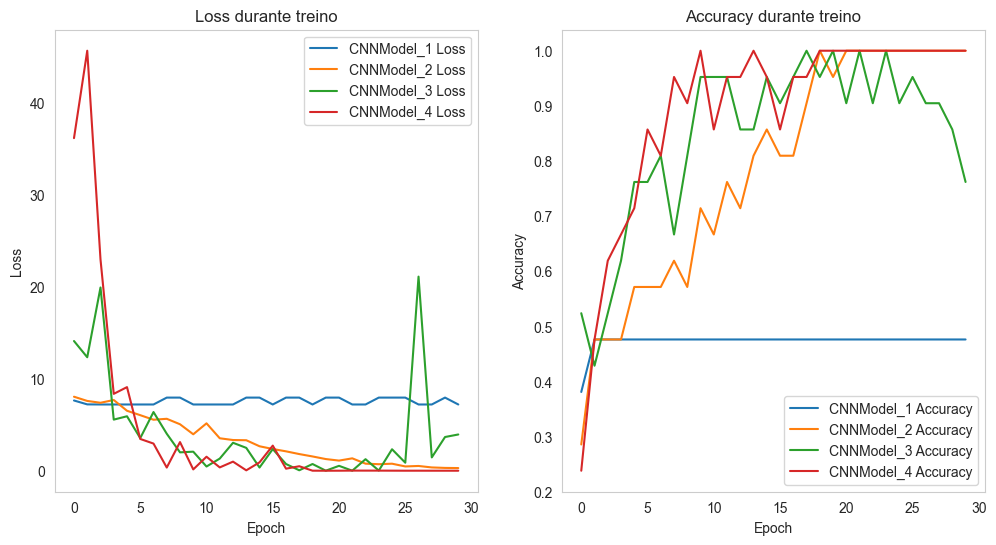

In [335]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot([h[0] for h in hist1], label='CNNModel_1 Loss')
plt.plot([h[0] for h in hist2], label='CNNModel_2 Loss')
plt.plot([h[0] for h in hist3], label='CNNModel_3 Loss')
plt.plot([h[0] for h in hist4], label='CNNModel_4 Loss')
plt.title('Loss durante treino')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot([h[1] for h in hist1], label='CNNModel_1 Accuracy')
plt.plot([h[1] for h in hist2], label='CNNModel_2 Accuracy')
plt.plot([h[1] for h in hist3], label='CNNModel_3 Accuracy')
plt.plot([h[1] for h in hist4], label='CNNModel_4 Accuracy')
plt.title('Accuracy durante treino')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()


In [336]:
torch.save(model1.state_dict(), "../outputs/models/model_task1_grs_cnn1.pt")
print("Modelo salvo!")

torch.save(model2.state_dict(), "../outputs/models/model_task1_grs_cnn2.pt")
print("Modelo salvo!")

torch.save(model3.state_dict(), "../outputs/models/model_task1_grs_cnn3.pt")
print("Modelo salvo!")

torch.save(model4.state_dict(), "../outputs/models/model_task1_grs_cnn4.pt")
print("Modelo salvo!")

Modelo salvo!
Modelo salvo!
Modelo salvo!
Modelo salvo!


# Evaluation

CNNModel_1 - Acurácia de Validação: 0.2500
CNNModel_2 - Acurácia de Validação: 0.5000


c:\Users\ruben\Desktop\Minho\MEI\SI\AP\.venv\Lib\site-packages\torch\nn\functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CNNModel_3 - Acurácia de Validação: 0.2500
CNNModel_4 - Acurácia de Validação: 0.5000
Melhor modelo: CNNModel_2 com Acurácia de Validação: 0.5000
Acurácia de Teste: 0.4000


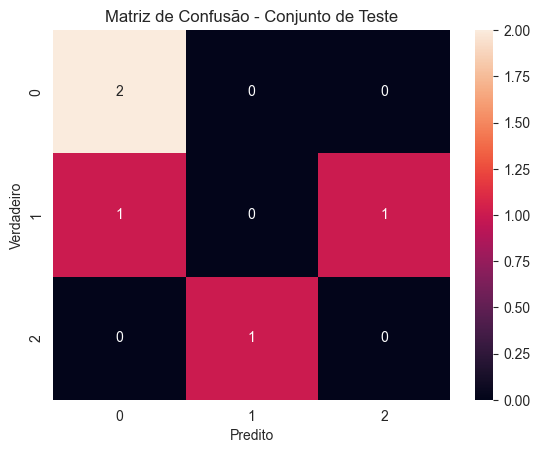

In [363]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir o critério de perda
criterion = torch.nn.CrossEntropyLoss()

# Lista de modelos a avaliar (apenas os que foram carregados com sucesso)
models_to_evaluate = ['CNNModel_1', 'CNNModel_2', 'CNNModel_3', 'CNNModel_4']

# Avaliar cada modelo no val_loader
val_results = {}
for name in models_to_evaluate:
    model = models[name]
    model.to(device)  # Garantir que o modelo está no dispositivo correto
    val_loss, val_acc = validate_model(model, val_loader, criterion)
    val_results[name] = val_acc
    print(f"{name} - Acurácia de Validação: {val_acc:.4f}")

# Encontrar o melhor modelo baseado na acurácia de validação
best_model_name = max(val_results, key=val_results.get)
best_model = models[best_model_name]
print(f"Melhor modelo: {best_model_name} com Acurácia de Validação: {val_results[best_model_name]:.4f}")

# Avaliar o melhor modelo no test_loader
test_loss, test_acc = validate_model(best_model, test_loader, criterion)
print(f"Acurácia de Teste: {test_acc:.4f}")

# Gerar e plotar a matriz de confusão
best_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusão - Conjunto de Teste')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()